In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc as smp
from PIL import Image
import numba
from numba import njit, vectorize, cuda
from timeit import default_timer as timer
from pylab import imshow, show
from tqdm import tqdm
import math

In [2]:
resolution = (1920*2,1080*2)
J_c = (-0.743643887037151,0.131825904205330)
J_z = 68227450827.50151

h2 = 1.5  # height factor of the incoming light
angle = -45  # incoming direction of light
v = np.exp(1j*angle*2*math.pi/360)

R = 100

@njit
def Julia(x, y, c, max_iterations):
    dz = complex(1,0)
    z = complex(x,y)

    for iterations in range(max_iterations):
        if (z.real*z.real + z.imag*z.imag) >= (R*R):
            u = z/dz
            u = u/abs(u)  # normal vector: (u.re,u.im,1) 
            t = u.real*v.real + u.imag*v.imag + h2  # dot product with the incoming light
            t = t/(1+h2)  # rescale so that t does not get bigger than 1
            if t<0: 
                t=0
            return t*255
        
        dz = dz*2*z
        z = z*z + c
        
    return 0

mandel_gpu = cuda.jit(device=True)(Julia)

@cuda.jit
def render_kernel(centre_x, centre_y, zoom, max_iter, rendergrid):
    xmin = - (3.5/(2*zoom))
    xmax =  (3.5/(2*zoom))
    ymin = - (2/(2*zoom))
    ymax = + (2/(2*zoom))

    pixel_width = (xmax-xmin)/resolution[0]
    pixel_height = (ymax-ymin)/resolution[1]
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y

    for i in range(startX, resolution[0], gridX):
        real = xmin + i*pixel_width
        for j in range(startY, resolution[1], gridY):
            imaginary = ymin + j*pixel_height
            colour = mandel_gpu(real,imaginary, complex(centre_x, centre_y), max_iter)
            rendergrid[j,i] = colour

Julia created on GPU in 1.651208 s


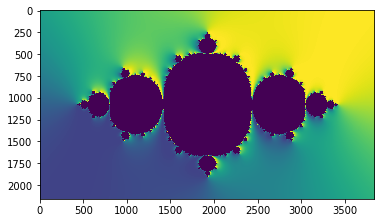

In [3]:
grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
blockdim = (32,8)
griddim = (32,16)

start = timer()
d_rendergrid = cuda.to_device(grendergrid)
render_kernel[griddim, blockdim](-0.78, 0, 0.9, 1000, d_rendergrid) 
d_rendergrid.to_host()
dt = timer() - start

print("Julia created on GPU in %f s" % dt)

imshow(grendergrid)
show()

In [ ]:
blockdim = (32,8)
griddim = (32,16)

frames = []
total_framecount = 720
lead_time=120

for i in tqdm(range(total_framecount+lead_time)):
    if i < lead_time:
        theta = 0
    else:
        theta = 0.25*((i-lead_time)*2*np.pi/total_framecount)
    r = complex(np.cos(-theta),0)
    #a = complex(0,theta)
    const = -2*r
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](const.real, const.imag, 0.85, 1000, d_rendergrid) 
    d_rendergrid.to_host()
    Image.fromarray( grendergrid ).save('julia_icicles_sinusoid' + str(i) + '.png')
    #colored = cm( grendergrid )
    #Image.fromarray((colored[:, :, :3] * 255).astype(np.uint8)).save(str(i)+' julia.png')# Create a PIL image
    #frames.append(img)

In [ ]:
#Icicles Linear
blockdim = (32,8)
griddim = (32,16)

frames = []
total_framecount = 120
cm = plt.get_cmap('rainbow')

for i in tqdm(range(total_framecount)):
    #theta = (i*2*np.pi/total_framecount)
    #r = complex(np.cos(theta),0)
    #a = complex(0,theta)
    const = 2*(i/total_framecount)-2
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](const.real, const.imag, 1, 1000, d_rendergrid) 
    d_rendergrid.to_host()
    Image.fromarray( grendergrid ).save('julia_icicles_linear' + str(i) + '.png')
    #colored = cm( grendergrid )
    #Image.fromarray((colored[:, :, :3] * 255).astype(np.uint8)).save(str(i)+' julia.png')# Create a PIL image
    #frames.append(img)

In [4]:
#Cardioid

blockdim = (32,8)
griddim = (32,16)

frames = []
total_framecount = 2880*2
cm = plt.get_cmap('rainbow')

for i in tqdm(range(total_framecount)):
    theta = (i*2*np.pi/total_framecount)
    r = 2*(1-np.cos(theta))
    #a = complex(0,theta)
    const = r*np.exp(complex(0,theta))
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](const.real, const.imag, 0.5, 1000, d_rendergrid) 
    d_rendergrid.to_host()
    Image.fromarray( grendergrid ).save('julia_cardioid_' + str(i) + '.png')
    #colored = cm( grendergrid )
    #Image.fromarray((colored[:, :, :3] * 255).astype(np.uint8)).save(str(i)+' julia.png')# Create a PIL image
    #frames.append(img)

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [03:48<00:00,  6.31it/s]


In [ ]:
2*np.pi*((4738/(2880*2))-(4735/(2880*2)))